
# 🚀 Day 18 — Hyperparameter Tuning & Model Optimization

**Notebook purpose:** A step-by-step, hands-on walkthrough of hyperparameter tuning techniques for regression problems.  
**Dataset used:** *California Housing* (scikit-learn). Note: the classic **Boston Housing** dataset is deprecated in recent versions of scikit-learn, so this notebook uses California Housing which is better practice for modern workflows.

This notebook covers:
- Baseline model building and evaluation
- Grid Search (exhaustive)
- Randomized Search (probabilistic)
- Bayesian / adaptive search using **Optuna**
- Visual diagnostics: learning curves, validation curves, and search result plots




In [ ]:

!pip install optuna xgboost scikit-learn matplotlib seaborn

print('If running locally, ensure optuna and xgboost are installed.')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.4 MB/s eta 0:00:00
If running locally, ensure optuna and xgboost are installed.


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, validation_curve, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

# Load California housing data
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

print('Dataset shape:', X.shape)
X.head()

Dataset shape: (20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
# Simple train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline model: Random Forest with default params
baseline = RandomForestRegressor(random_state=42, n_jobs=-1)
t0 = time.time()
baseline.fit(X_train_scaled, y_train)
t1 = time.time()

y_pred = baseline.predict(X_test_scaled)
print('Baseline RandomForest Regressor — Time: {:.2f}s'.format(t1-t0))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))


Baseline RandomForest Regressor — Time: 18.14s
MSE: 0.255169737347244
RMSE: 0.5051432839771741
MAE: 0.3274252027374033
R2: 0.8052747336256919


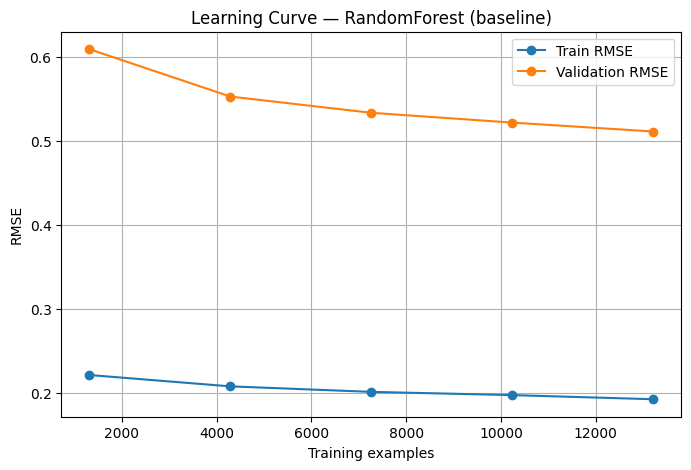

In [ ]:

# Plot learning curve for baseline
train_sizes, train_scores, val_scores = learning_curve(baseline, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(.1,1.0,5))

train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, np.sqrt(train_scores_mean), 'o-', label='Train RMSE')
plt.plot(train_sizes, np.sqrt(val_scores_mean), 'o-', label='Validation RMSE')
plt.xlabel('Training examples')
plt.ylabel('RMSE')
plt.title('Learning Curve — RandomForest (baseline)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Grid search for RandomForest (small grid for demo)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)

print('Best params (GridSearch):', grid.best_params_)
best_rf = grid.best_estimator_

y_pred_grid = best_rf.predict(X_test_scaled)
print('GridSearch MSE:', mean_squared_error(y_test, y_pred_grid))
print('GridSearch RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_grid)))
print('GridSearch R2:', r2_score(y_test, y_pred_grid))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params (GridSearch): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
GridSearch MSE: 0.25381644520158614
GridSearch RMSE: 0.5038019900730704
GridSearch R2: 0.8063074586513359


In [ ]:
from scipy.stats import randint as sp_randint
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': sp_randint(50, 150),
    'learning_rate': [0.05, 0.1],
    'max_depth': sp_randint(2, 5),
    'subsample': [0.8, 1.0],
    'min_samples_split': sp_randint(2, 8)
}

gbr = GradientBoostingRegressor(random_state=42)
rand = RandomizedSearchCV(
    gbr,
    param_distributions=param_dist,
    n_iter=5,    # ↓ faster
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand.fit(X_train_scaled, y_train)

print('Best params:', rand.best_params_)
y_pred_rand = rand.best_estimator_.predict(X_test_scaled)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_rand)))
print('R2:', r2_score(y_test, y_pred_rand))


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_split': 7, 'n_estimators': 102, 'subsample': 1.0}
RMSE: 0.5100012940937094
R2: 0.801511341652726


In [ ]:
# Optuna example optimizing an XGBoost regressor
# If xgboost or optuna are not installed in your env, run: pip install xgboost optuna

import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
    }
    model = XGBRegressor(**params, random_state=42, n_jobs=-1, verbosity=0)
    scores = cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    return -1.0 * np.mean(scores)

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=40, show_progress_bar=True)

print('Best trial:')
print(study.best_trial.params)

# Train final XGBoost with best params
best_params = study.best_trial.params
xgb_best = XGBRegressor(**best_params, random_state=42, n_jobs=-1, verbosity=0)
xgb_best.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_best.predict(X_test_scaled)
print('Optuna XGBoost MSE:', mean_squared_error(y_test, y_pred_xgb))
print('Optuna XGBoost RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Optuna XGBoost R2:', r2_score(y_test, y_pred_xgb))


[I 2025-10-18 01:43:17,350] A new study created in memory with name: no-name-e3cef5be-11b5-4847-bdda-52a64eec62d8


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-10-18 01:43:31,773] Trial 0 finished with value: 0.32308903090439206 and parameters: {'n_estimators': 218, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.40921304830970556, 'reg_alpha': 2.5348407664333426e-07, 'reg_lambda': 3.3323645788192616e-08}. Best is trial 0 with value: 0.32308903090439206.
[I 2025-10-18 01:43:42,274] Trial 1 finished with value: 0.22650898223093244 and parameters: {'n_estimators': 440, 'max_depth': 8, 'learning_rate': 0.11114989443094977, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.978936896513396, 'reg_alpha': 0.31044435499483225, 'reg_lambda': 8.148018307012941e-07}. Best is trial 1 with value: 0.22650898223093244.
[I 2025-10-18 01:43:42,857] Trial 2 finished with value: 0.33341917541898924 and parameters: {'n_estimators': 132, 'max_depth': 4, 'learning_rate': 0.028145092716060652, 'subsample': 0.762378215816119, 'colsample_bytree': 0.602361513049481, 'reg_alpha': 4.17890272377219

In [17]:

# Optional visualizations (may require additional packages)
try:
    import optuna.visualization as ov
    fig = ov.plot_param_importances(study)
    fig.show()
except Exception as e:
    print('Optuna visualization could not be shown in this environment:', e)

In [19]:
# Compare baseline, grid, randomized, and optuna results in a DataFrame
results = []

# Baseline RF
baseline_pred = baseline.predict(X_test_scaled)
results.append([
    'Baseline RF',
    mean_squared_error(y_test, baseline_pred),
    np.sqrt(mean_squared_error(y_test, baseline_pred)),
    r2_score(y_test, baseline_pred)
])

# GridSearch RF
results.append([
    'GridSearch RF',
    mean_squared_error(y_test, y_pred_grid),
    np.sqrt(mean_squared_error(y_test, y_pred_grid)),
    r2_score(y_test, y_pred_grid)
])

# Randomized GBR
results.append([
    'Randomized GBR',
    mean_squared_error(y_test, y_pred_rand),
    np.sqrt(mean_squared_error(y_test, y_pred_rand)),
    r2_score(y_test, y_pred_rand)
])

# Optuna XGB
results.append([
    'Optuna XGB',
    mean_squared_error(y_test, y_pred_xgb),
    np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    r2_score(y_test, y_pred_xgb)
])

df_results = pd.DataFrame(results, columns=['Model', 'MSE', 'RMSE', 'R2']).sort_values('RMSE')
df_results.style.format({'MSE': '{:.4f}', 'RMSE': '{:.4f}', 'R2': '{:.4f}'})


,Model,MSE,RMSE,R2
3,Optuna XGB,0.1947,0.4413,0.8514
1,GridSearch RF,0.2538,0.5038,0.8063
0,Baseline RF,0.2552,0.5051,0.8053
2,Randomized GBR,0.2601,0.5100,0.8015
